# Proyecto Natural Language Processing (NLP):

In [ ]:
# Librería para la declaración y uso de Data Frames:
import pandas as pd

# Librería para la utilización de Expresiones Regulares:
import re

# Librería para la utilización de herramientas para NLP:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords');
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet');

# Librería para mostrar la barra de progreso de bucles y funciones:
from tqdm import tqdm
tqdm.pandas();

# Librería para generar la nube de palabras:
from wordcloud import WordCloud

# Librería para poder generar gráficos:
import matplotlib.pyplot as plt

# Librería para poder realizar la partición entre train y test set:
from sklearn.model_selection import train_test_split

# Librería útil para realizar la conversión de palabras a vectores:
from sklearn.feature_extraction.text import TfidfVectorizer

# Librería para contruir una SVM:
from sklearn.svm import SVC

# Librería para utilizar modelos de optimización de hiperparámetros:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Librería para obtener las métricas de las predicciones:
from sklearn.metrics import classification_report, accuracy_score

# Librería para poder obtener valores aleatorios enteros:
from scipy.stats import uniform


[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Paso 1 - Lectura de Datos: 

En primer lugar, es necesario **leer y guardar la información** en una variable para poder empezar a trabajar con ella.

Para ello, se ha guaradado el archivo con todos los datos en la ruta: */workspaces/NLP-clara-ab/data/raw/url_spam.csv* y se ha cargado en un Data Frame:

In [52]:
# Lectura del CSV con los datos, dada la ruta donde se guarda el archivo (se ha evitado cargar la primera columna con los índices de las filas):
df = pd.read_csv ('/workspaces/NLP-clara-ab/data/raw/url_spam.csv', sep = ",");

# Configuración de pandas para mostrar todas las columnas del DataFrame sin truncarlas al visualizarlo:
pd.set_option('display.max_columns', None);

# Se muestran las 5 primeras filas del Data Frame:
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


Una vez se ha cargado correctamente la información en el Data Frame df es interesante evaluar la **cantidad de información que se tiene**. Para ello, se recurre al atributo `shape` del Data Frame:

In [53]:
# Se utiliza el atributo shape del Data Frame para conocer cuánta información está cargada:
print(f" El archivo cargado contiene {df.shape[0]} URLs"); 

 El archivo cargado contiene 2999 URLs


Además, tal y como se ha visto en el **breve resumen** mostrado a partir de `.head()` la variable a predecir, `is_spam` tiene dos valores posibles: `True` or `False`. 

En este caso, nos interesa predecir si una URL es SPAM, es decir, **detectar el `TRUE`**. Por lo que se va a realizar un cambio de forma que, en todas las filas donde la columna `is_spam` sea `True`, se convertirán a `1` y donde haya un `False` se convertirán a `0`. 

Para no tener problemas, es importante comprobar, primero el **tipo de variable** que se encuentra en la columna `is_spam`:

In [54]:
# Se imprimen los tipos de variables de las dos columnas del DataFrame:
print(df.dtypes)

url        object
is_spam      bool
dtype: object


Ahora que se sabe que es un **boolean**, se puede realizar la conversión con la función `map()` de forma segura:

In [55]:
# Se codifica la columna objetivo:
df['is_spam'] = df['is_spam'].astype(bool).map({True: 1, False: 0})

# Se comprueba que se ha codificado correctamente: 
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


## Paso 2 - Análisis Exploratorio de Datos (Previo):

Antes de pasar el preprocesado de texto, donde se prepara al conjunto de datos para el análisis, es necesario realizar un **análisis exploratorio de los datos previo** de forma que se puedan **eliminar redundancias o datos faltantes** y no trabajar sobre ellos de forma innecesaria en el paso siguiente. 


### Paso 2.1 - Análisis de Duplicados:

In [56]:
# Se utiliza el método .duplicated() para identificar las URL repetidas dentro del DataFrame:
print(f" Hay un total de {df.duplicated().sum()} URLs duplicadas.");

 Hay un total de 630 URLs duplicadas.


Se han encontrado un total de 630 URLs duplicadas que se deben eliminar:

In [57]:
# Se eliminan los duplicados:
df_clean = df.drop_duplicates();

# Se comprueba que ya no quedan duplicados:
print(f" Hay un total de {df_clean.duplicated().sum()} URLs duplicadas.");

 Hay un total de 0 URLs duplicadas.


### Paso 2.2 - Análisis de Nulos:

In [58]:
# Se comprueba el porcentaje de filas que presentan al menos un valor nulo:
print(f" El {round(df_clean.isnull().any(axis=1).mean()*100, 2)} % de las filas presentan, al menos, un valor nulo");

 El 0.0 % de las filas presentan, al menos, un valor nulo


No tenemos ninguna fila con valores nulos.

## Paso 3 - Pre-Procesado de Texto:

Una vez ya se tiene guardado el conjunto de datos con una breve **limpieza previa**, se puede pasar a realizar un **preprocesado del texto a estudiar**, en este caso  las URLs.

El **preprocesamiento de texto** es un paso **crucial** en el análisis de información textual, dado que ayuda a **transformar la información en bruto en un formato más estructurado y útil** para modelos de Machine Learning. De esta forma, se ayuda a eliminar el *ruido* desechando los patrones, *a priori*, irrelevantes. 

Para ello, se van a utilizar **dos librerías** imprescindibles en el procesado de texto: 

**- `re`:** Librería de Python utilizada para trabajar con **expresiones regulares** (secuencia de caracteres que definen un patrón de búsqueda). Es útil para **segementar y limpiar textos** mediante diferentes patrones. En este caso, va a permitir dividir las URLs por caracteries especiales y eliminar todos los elementos no deseados. 

**- `nltk` Natural Language Toolkit:** Librería de Python con **herramientas** útiles para el procesado de lenguaje natural como *stopwords*, lematización y tokenización, lo que facilita la **normalización** del texto antes de aplicar cualquier modelo de Machine Learning. 

En este caso, se van a realizar **7 pasos**: 

1. Conversión del texto a minúscula

2. Eliminado de palabras sin valor

3. Segmentación de las URLs (Tokenización)

4. Eliminado de *StopWords*

5. Lematización

6. Eliminado final de espacios y letras aisladas

7. Conversión de palabras a vectores

### Paso 3.1 - Pre-Procesado Inicial:

Para poder realizar todo este preprocesado, se va a utilizar una **función** que reciba como **input** el **texto a preprocesar**, es decir, las URLs y se **devuelvan preprocesadas** habiendo realizado los **6 primeros pasos** mencionados. 

In [59]:
# # # Función de PreProcesado de Texto # # #
def preprocess_text (url):

    # 1. Conversión a minúsculas:
    url = url.lower();
      
    # 2. Eliminado de palabras irrelevantes:
    url = re.sub(r'https?://|www\.', '', url); # Borrado de Protocolo Web (http, https, www)
    url = re.sub(r'\s*\d+\s*', ' ', url);  # Borrado de números aislados
    url = re.sub(r'\b[a-zA-Z]*\d+[a-zA-Z]*\b', ' ', url);  # Borrado de palabras con mezcla de letras y números
    url = re.sub(r'#.*', ' ', url); # Borrado de signos especiales como hashtags
    url = re.sub(r'\b[a-zA-Z]\b', '', url); # Borrado de letras aisladas

    # 3. Segmentado de las URLs:
    tokens = re.split(r'[\/\.\?\=\&\-_]', url);
    
    # 4. Eliminado de StopWords:
    stop_words = set(stopwords.words('english')); # Se guardan las StopWords de Inglés (idioma en el que están las URLs)
    tokens = [token for token in tokens if token not in stop_words]; # Se comprueba para cada palabra de la segmentación

    # 5. Lematización de palabras
    lemmatizer = WordNetLemmatizer(); # Se instancia el Lematizador
    tokens = [lemmatizer.lemmatize(token) for token in tokens]; # Se utiliza para cada palabra de la segmentación

    # 6. Eliminado final de espacios y letras sueltas:
    tokens = [token.strip() for token in tokens if token and len(token) > 1]; # Se comprueba la longitud de cada palabra de la segmentación

    return ' '.join(tokens);

Antes de pasar todo el conjunto de datos por la función creada, para conseguir el preprocesado de texto, se va a **comprobar su funcionamiento** a través de URLs obtenidas de forma aleatoria.

In [60]:
# Se guarda una URL aleatoria:
url_random = df_clean.sample(1).url.values[0];

# Se imprime la URL antes de ser procesada:
print(f'URL antes de ser preprocesada:\n {url_random}');
print('-'*50);

# Se llama a la función de preprocesado:
url_random_prepro = preprocess_text(url_random);

# Se imprime la URL después del preprocesado:
print(f'URL tras ser preprocesada:\n {url_random_prepro}');

URL antes de ser preprocesada:
 https://trends.co/
--------------------------------------------------
URL tras ser preprocesada:
 trend co


Una vez se ha comprobado con varias pruebas que las **expresiones regulares empleadas y el resto de funciones utilizadas actúan como se desea**, se puede proceder a pasar todo el conjunto de datos por el preprocesado. 

En este caso, se ha decidido declarar una **nueva columna** en el DataFrame, de forma que se guarden ahí las URL preprocesadas.

In [61]:
# Se llama a la función y se ve el progreso:
df_clean['url_prepro'] = df_clean['url'].progress_apply(preprocess_text);

# Se comprueba el guardado de la información:
df_clean.head()

100%|██████████| 2369/2369 [00:00<00:00, 6541.77it/s]
/tmp/ipykernel_663/1632735105.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['url_prepro'] = df_clean['url'].progress_apply(preprocess_text);


,url,is_spam,url_prepro
0,https://briefingday.us8.list-manage.com/unsubs...,1,briefingday us list manage com unsubscribe
1,https://www.hvper.com/,1,hvper com
2,https://briefingday.com/m/v4n3i4f3,1,briefingday com
3,https://briefingday.com/n/20200618/m#commentform,0,briefingday com
4,https://briefingday.com/fan,1,briefingday com fan


Habiendo comprobado que la información se guarda de forma correcta, se puede **borrar la columna `url`** al ya no ser relevante para la clasificación. 

In [62]:
 # Se borra la columna 'url':
df_clean = df_clean.drop(['url'], axis = 1);

# Se comprueba el correcto borrado:
df_clean.head()

,is_spam,url_prepro
0,1,briefingday us list manage com unsubscribe
1,1,hvper com
2,1,briefingday com
3,0,briefingday com
4,1,briefingday com fan


### Paso 3.2 - Análisis Exploratorio de Datos (Posterior):

Después de realizar el preprocesado de datos inicial, es posible que se hayan generado nuevas filas con **valores faltantes** o **duplicados**. Por esta razón, es importante volver a realizar una **breve limpieza** donde se detecten estos casos y se eliminen antes de pasar al último paso del preprocesado.

#### Análisis de Duplicados:

In [63]:
# Se utiliza el método .duplicated() para identificar las URL repetidas dentro del DataFrame:
print(f" Hay un total de {df_clean.duplicated().sum()} URLs duplicadas.");

 Hay un total de 80 URLs duplicadas.


In [64]:
# Se eliminan los duplicados:
df_prepro = df_clean.drop_duplicates();

# Se comprueba que ya no quedan duplicados:
print(f" Hay un total de {df_prepro.duplicated().sum()} URLs duplicadas.");

 Hay un total de 0 URLs duplicadas.


#### Análisis de Nulos:

In [65]:
# Se comprueba el porcentaje de filas que presentan al menos un valor nulo:
print(f" El {round(df_prepro.isnull().any(axis=1).mean()*100, 2)} % de las filas presentan, al menos, un valor nulo");

 El 0.0 % de las filas presentan, al menos, un valor nulo


Después de esta última limpieza, es interesante comprobar **cuántas URLs se han borrado** para ser consciente del volumen de datos con el que se cuenta para el análisis.

In [66]:
# Se imprime el resumen del número de URLs bajo estudio: 
print(f" Después de todo el preprocesado, se han eliminado un total de {abs(df.shape[0] - df_prepro.shape[0])} URLs, contando actualmente con {df_prepro.shape[0]} URLs para el análisis, es decir, con un {round(100*(df_prepro.shape[0]/df.shape[0]), 2)} %");

 Después de todo el preprocesado, se han eliminado un total de 710 URLs, contando actualmente con 2289 URLs para el análisis, es decir, con un 76.33 %


### Paso 3.3 - Nube de Palabras:

Por último, antes de llegar al séptimo paso, donde se van a convertir las palabras a vectores, es interesante **visualizar las palabras más frecuentes** y términos clave de ambos tipo de URL (spam y no spam). 

Para ello, en primer lugar, se van a **separar en dos variables** las URL según la columna `is_spam` para tener divididas las dos categorías y, posteriormente, se va a **instanciar un objeto** de la clase `WordCloud` para cada una. De esta forma, se van a pasar las URLs y se van a **generar Nubes de Palabras** mostrando aquellas de mayor ocurrencia. 

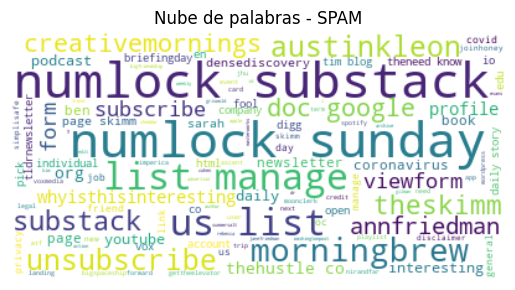

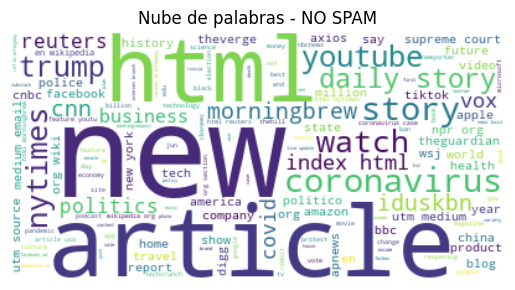

In [67]:
# Se separan las URLs en dos grupos según si son (1) o no (0) spam :
spam_url = ' '.join(df_prepro[df_prepro['is_spam'] == 1]['url_prepro']);
no_spam_url = ' '.join(df_prepro[df_prepro['is_spam'] == 0]['url_prepro']);

# # # Nube de Palabras - SPAM # # #
wordcloud_spam = WordCloud(background_color = "white", max_words = 500, contour_color = "steelblue", collocations = True);
wordcloud_spam.generate(spam_url);
plt.imshow(wordcloud_spam, interpolation='bilinear');
plt.axis('off');
plt.title("Nube de palabras - SPAM");
plt.show();

# # # Nube de Palabras - NO SPAM # # #
wordcloud_no_spam = WordCloud(background_color = "white", max_words = 500, contour_color = "steelblue", collocations = True);
wordcloud_no_spam.generate(no_spam_url);
plt.imshow(wordcloud_no_spam, interpolation='bilinear');
plt.axis('off');
plt.title("Nube de palabras - NO SPAM");
plt.show();

Algo que es muy interesante evaluar cuando se obtienen Nubes de Palabras es comprobar que **no aparecen las mismas palabras en las categorías** en las que estemos diferenciando. Esto es importante dado que, si las palabras con mayor frecuencia de todas las categorías son las mismas, **no sirven realmente para poder diferenciar entre ellas** y, por lo tanto, **no resultan útiles**. 

En este caso, sin embargo, **no se pueden ver palabras repetidas en ambas Nubes de Palabras**, por lo que se puede entender que sí hay palabras frecuentes en cada una de las categorías que van a permitir realizar una clasificación fiable. 

### Paso 3.4 - Vectorización de las Palabras:

Finalmente, se llega al último paso del PreProcesado de datos, en el que es necesario pasar las palabras a vectores, en tanto que los algoritmos de Machine Learning no trabajan con palabras y es necesario realizar esta codificación. 

En este caso, se va a aplicar el **TF-IDF Vectorization** para transformar el texto en vectores que reflejen la importancia de cada palabra dentro de todo el conjunto de datos. Esto es particularmente útil en problemas de clasificación dado que ayuda a mantener la relevancia de los términos. 

Sin embargo, para ello, es necesario antes realizar la partición del conjunto de datos entre *train* y *test* set con la función `train_test_split` dejando un 20% del total para probar el modelo:

In [68]:
# Se realiza la separación entre Train y Test Set:
X_train, X_test, y_train, y_test = train_test_split(df_prepro ['url_prepro'], df_prepro ['is_spam'], test_size = 0.2, random_state = 42);

Ahora que ya se tiene el conjunto de datos dividido, se puede instanciar un objeto de la clase `TfidVectorizer()` para entrenarlo con el *train set* y aplicarlo sobre ambos *sets*. 

In [69]:
# Se instancia un Vectorizador:
vectorizer = TfidfVectorizer();

# Se entrena y aplica sobre el Train Set:
X_train_vec = vectorizer.fit_transform(X_train);

# Se aplica sobre el Test Set:
X_test_vec = vectorizer.transform(X_test)

## Paso 4 - Construcción del Modelo SVM:

Una vez ya se tiene todo el texto preprocesado, se puede pasar a aplicar un modelo para poder detectar las URL que son SPAM. 

Con este objetivo, se va a aplicar un algoritmo de aprendizaje llamado ***Support Vector Machine (SVM)***. Este modelo tiene como objetivo encontrar un hiperplano óptimo que separe las categorías del conjunto de datos, es decir, intenta generar un plano para maximizar la distancia entre los puntos más cercanos de cada clase. 

En este caso, al tratar con un prolema de clasificación se va a utilizar un SVM de la librería `scikit-learn` llamado ***Support Vector Classififer (SVC)*** que además permite utilizar algoritmos de **optimización de hiperparámetros** para llegar a la mejor predicción posible. 

Sin embargo, antes de poder analizar las mátricas, es importante saber **cómo de balanceado está el conjunto de datos**, en tanto que si hay predominancia hacia una de las clases, las **métricas se van a ver influidas** por ello.

In [70]:
# Se comprueba cómo de balanceado se encuentra el conjunto de datos:
df_prepro['is_spam'].value_counts()

is_spam
0    2055
1     234
Name: count, dtype: int64

El **desbalance encontrado es muy grande**, teniendo muchas más **URLs no etiquetadas como SPAM** (clase = 0). Esto va a influir notablemente en el análisis de las métricas dado que es mucho **más probable que el modelo prediga la clase mayoritaria** que la minoritaria.

Teniendo esto en cuenta, se van a generar **tres modelos** para analizar sus métricas: 

**1.** SVC sin optimización

**2.** SVC con optimización por `GridSearchCV`

**3.** SVC con optimización por `RandomSearchCV`

### Paso 4.1 - Sin Optimización:

En primer lugar, se van a obtener las predicciones a partir del **modelo sin optimizar** ninguno de sus hiperparámetros.

Para ello, simplemente se va a instanciar un objeto de la clase `SVC`, se va a **entrenar** con el *train set* y se va a **aplicar** sobre el *test set* para obtener las métricas con la función `classification_report`

In [71]:
# Se define el modelo SVM de Clasificación: 
svm_model = SVC();

# Se ajusta el modelo con los datos de entrenamiento:
svm_model.fit(X_train_vec, y_train);

# Se obtiene la predicción para el conjunto de test:
y_pred = svm_model.predict(X_test_vec);

# Se imprimen las métricas:
print("\n Métricas de la Predicción - Sin Optimización:");
print(classification_report(y_test, y_pred));
print(f" Exactitud: {round(100*accuracy_score(y_test, y_pred), 2)} %");



 Métricas de la Predicción - Sin Optimización:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       412
           1       0.86      0.39      0.54        46

    accuracy                           0.93       458
   macro avg       0.90      0.69      0.75       458
weighted avg       0.93      0.93      0.92       458

 Exactitud: 93.23 %


El modelo sin optimización presenta una **alta precisión general**, algo superior al 93%, sin embargo, muestra un **desequilibrio evidente** en la detección de URLs que sí son SPAM (clase = 1).

La **precisión en la detección es del 86%**, valor alto frente al **39% de la Sensibilidad** (Recall), lo que deja ver que hay muchos **casos de SPAM no detectados**. Por ello, se puede ver cómo el modelo está claramente **favoreciendo a la clase mayoritaria** (NO SPAM). 

### Paso 4.2 - Con Optimización:

Para tratar de mejorar los resultados obtenidos, se van a probar **dos técnicas de optimización**:

- GridSearch (Búsqueda por cuadrícula)

- RandomSearch (Búsqueda Aleatoria)

Los **hiperparámetros a optimizar** van a ser únicamente tres en ambas técnicas:

- **Control de Regularización `C` :** Parámetro que trata de **evitar el sobreajuste** de los datos. Cuanto **más grande sea C**, el modelo se ajustará más a los datos (**menos regularización**) y cuanto **más pequeño sea C**, el modelo será más simple y evitará el sobreajuste (**más regularización**).

- **Kernel :** Parámetro que define el tipo de **frontera de decisión**. Las opciones más comunes son **linear** (para datos lineales), **polynomial** (para relaciones polinómicas), **RBF** (para datos no lineales y sin una distribución clara) y **sigmoid** (para un comportamiento similar al de las redes neuronales).

- **Gamma :** Parámetro que controla el alcance de la influencia de los puntos de entrenamiento, afectando a la *suavidad* de la frontera de decisión. Los **valores altos** pueden llegar a causar **sobreajuste**, mientras que los **valores bajo**s suelen **generalizar mejor**.

#### Grid Search:

In [72]:
# Se define el modelo SVM de Clasificación: 
svm_model = SVC();

# Se define el espacio de búsqueda de hiperparámetros:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1]
};

# Se configura la malla de búsqueda, GridSearchCV:
grid_search = GridSearchCV(estimator = svm_model, param_grid = param_grid, cv = 5, verbose = 1, n_jobs = -1);

# Se ajusta el modelo con los datos de entrenamiento:
grid_search.fit(X_train_vec, y_train);

# Se muestran los mejores hiperparámetros encontrados los mejores hiperparámetros encontrados
print(f"\n\nMejores hiperparámetros: {grid_search.best_params_}\n\n");

# Se guarda el mejor modelo:
best_grid_SVC= grid_search.best_estimator_;

# Se obtiene la predicción para el conjunto de test:
y_pred_grid = best_grid_SVC.predict(X_test_vec);

# Se imprimen las métricas:
print("\n Métricas de la Predicción - Con Optimización (GridSearch):");
print(classification_report(y_test, y_pred_grid));
print(f" Exactitud: {round(100*accuracy_score(y_test, y_pred_grid), 2)} %");


Fitting 5 folds for each of 64 candidates, totalling 320 fits


Mejores hiperparámetros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}



 Métricas de la Predicción - Con Optimización (GridSearch):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       412
           1       0.62      0.63      0.62        46

    accuracy                           0.92       458
   macro avg       0.79      0.79      0.79       458
weighted avg       0.92      0.92      0.92       458

 Exactitud: 92.36 %


En este caso, al aplicar una optimización de tipo `GridSearch` se ha obtenido una **ligera pérdida de la exactitud** con respecto a las métricas obtenidas en el modelo sin optimizar. 

Sin embargo, la** mejora en el Recal**l para la clase de SPAM es evidente, habiendo pasado de un 39% a un 63%, aunque con una **precisión más baja**. 

Debido a todo esto, se puede comprobar que la **optimización ha ayudado a identificar más casos de SPAM**, a costa de una **mayor cantidad de falsos positivos**. 

#### Random Search:

In [73]:
# Se define el modelo SVM de Clasificación:
svm_model = SVC();

# Se define el espacio de búsqueda de hiperparámetros:
parameters = {
    'C': uniform(0.1, 1000),  
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
    'gamma': ['scale', 'auto', uniform(0.01, 1)]  
};

# Se configura la búsqueda aleatoria, RandomizedSearchCV:
random_search = RandomizedSearchCV(estimator = svm_model, param_distributions = parameters, n_iter = 100, cv = 5, verbose = 1, random_state = 42, n_jobs = -1);

# Se ajusta el modelo con los datos de entrenamiento:
random_search.fit(X_train_vec, y_train);

# Se muestran los mejores hiperparámetros encontrados:
print(f"\n\nMejores hiperparámetros: {random_search.best_params_}\n\n");

# Se guarda el mejor modelo:
best_random_SVC = random_search.best_estimator_;

# Se obtiene la predicción para el conjunto de test:
y_pred_random = best_random_SVC.predict(X_test_vec);

# Se obtienen las métricas:
print("\n Métricas de la Predicción - Con Optimización (RandomSearch):");
print(classification_report(y_test, y_pred_random));
print(f"\nExactitud: {round(100 * accuracy_score(y_test, y_pred_random), 2)} %");

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/vscode/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
145 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/home/vscode/.loca



Mejores hiperparámetros: {'C': np.float64(374.6401188473625), 'gamma': 'scale', 'kernel': 'rbf'}



 Métricas de la Predicción - Con Optimización (RandomSearch):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       412
           1       0.46      0.54      0.50        46

    accuracy                           0.89       458
   macro avg       0.71      0.74      0.72       458
weighted avg       0.90      0.89      0.89       458


Exactitud: 89.08 %


Las métricas obtenidas con el modelo optimizado con `RandomSearchCV` han sido peores que las analizadas para el caso del modelo cuyos hiperparámetros han sido optimizados usado `GridSearchCV`. La exactitud global ha sido la peor de los tres casos y, aunque la Sensibilidad (Recall) ha quedado por encima que en el caso sin optimizar, no ha superado el 63% obtenido mediante `GridSearch`.

De esta forma se puede concluir con que los mejores hiperparámetros han sido: 

- **Control de Regularización `C` :** 10

- **Kernel :** RBF

- **Gamma :** 0.1

In [74]:
# Se define el modelo SVM de Clasificación: 
svm_model = SVC(C = 10, kernel = 'rbf', gamma = 0.1);

# Se ajusta el modelo con los datos de entrenamiento:
svm_model.fit(X_train_vec, y_train);

# Se obtiene la predicción para el conjunto de test:
y_pred = svm_model.predict(X_test_vec);

# Se imprimen las métricas:
print("\n Métricas de la Predicción - Mejor Modelo:");
print(classification_report(y_test, y_pred));
print(f" Exactitud: {round(100*accuracy_score(y_test, y_pred), 2)} %");


 Métricas de la Predicción - Mejor Modelo:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       412
           1       0.62      0.63      0.62        46

    accuracy                           0.92       458
   macro avg       0.79      0.79      0.79       458
weighted avg       0.92      0.92      0.92       458

 Exactitud: 92.36 %
